<a href="https://colab.research.google.com/github/lechiffre7/Keystroke-and-mouse-dynamic-for-Credit-Card-Fraud-Detection/blob/main/overview_of_biometric_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  
# **Feature extraction of keystroke dynamic and mouse dynamic on Mendeley dataset**

</center>




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import json
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

## Implementation of some useful functions for the extractions.

In [22]:
# Define a function to parse the data into DataFrames

def parse_data(data, test_number, event_type):

    # Initialize a list to collect events
    collect_events = []

    # Iterate over the data dictionary
    for event_group_key, event_group in data.items():
        # Check if the current event group matches the specified event type
        if event_group_key == event_type:
            # Iterate over the events in the current event group
            for event in event_group:
                # Add the test number to each event
                event['Test Number'] = test_number.split('_')[1]
                # Append the event to the list of collected events
                collect_events.append(event)

    # Create a DataFrame from the collected events
    df = pd.DataFrame(collect_events)

    return df

################################################################################################################################

# Define a function to filter keyboard events
def filter_keyboard(df):

  '''
  Remove some outliers on the keyboard events
  '''

  filtered_rows = []
  i = 0
  while i < len(df):
      if df.iloc[i]['Event'] == 'pressed':
          if i+1 < len(df) and df.iloc[i+1]['Event'] == 'released' and df.iloc[i]['Key'] == df.iloc[i+1]['Key']:
              filtered_rows.append(df.iloc[i])
              filtered_rows.append(df.iloc[i+1])
              i += 2
          else:
              i += 1
      else:
          i += 1
  return pd.DataFrame(filtered_rows)

################################################################################################################################

# Define a function to calculate hold times and down-down times

def calculate_times(df):
    '''
    The hold time is a key event defined by: release_time - press_time,
    The down-down time is an inter-key event defined by: press_time_key1 - press_time_key2
    And everything is grouped by test number.
    '''

    dataframes = {}  # Dictionary to store DataFrame for each test number
    grouped_df = df.groupby('Test Number')  # Group DataFrame by Test_Number
    for test_number, group in grouped_df:
        hold_times = []  # List to store hold times
        down_down_times = []  # List to store down-down times
        for i in range(len(group) - 1):
            current_row = group.iloc[i]
            next_row = group.iloc[i + 1]
            if current_row['Event'] == 'pressed':
                if next_row['Event'] == 'released':
                    # Calculate hold time if current event is pressed and next event is released
                    hold_time = (pd.to_datetime(next_row['Timestamp']) - pd.to_datetime(current_row['Timestamp'])).total_seconds()
                    hold_times.append(hold_time)
            if i % 2 == 0 and i < len(group) - 2:
                next_next_row = group.iloc[i + 2]
                # Calculate down-down time every two pressed events
                down_down_time = (pd.to_datetime(next_next_row['Timestamp']) - pd.to_datetime(current_row['Timestamp'])).total_seconds()
                down_down_times.append(down_down_time)

        # Adjust lists to have the same length
        max_length = max(len(hold_times), len(down_down_times))
        hold_times += [None] * (max_length - len(hold_times))
        down_down_times += [None] * (max_length - len(down_down_times))

        # Create DataFrame for the current test number
        test_df = pd.DataFrame({'Hold_Time': hold_times, 'Down_Down_Time': down_down_times})
        dataframes[test_number] = test_df  # Store DataFrame in dictionary with test number as key

    return dataframes




######################################################################################################

# Function to calculate speed
def calculate_speed(coord1, coord2, timestamp1, timestamp2):
    # Convert coordinate lists/tuples to floats
    coord1 = tuple(map(float, coord1))
    coord2 = tuple(map(float, coord2))

    # Calculate distance between two coordinates
    distance = ((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1])**2)**0.5

    # Calculate time difference in seconds
    time_difference = (timestamp2 - timestamp1).total_seconds()

    # Check for zero time difference
    if time_difference == 0:
        return 0  # Return zero speed

    # Calculate speed (distance / time)
    speed = distance / time_difference

    return speed

##########################################################################################################


# Function to calculate time difference
def calculate_click_time(group_df):
    # Initialize an empty list to store time differences
    time_diffs = []

    # Iterate through the DataFrame
    for i in range(0, len(group_df), 2):  # Iterate by twos
        # Check if the current and next events are 'left press' and 'left release'
        if group_df.iloc[i]['Event'] == 'left press' and group_df.iloc[i + 1]['Event'] == 'left release':
            # Calculate the time difference between 'left press' and 'left release'
            click_time = (group_df.iloc[i + 1]['Timestamp'] - group_df.iloc[i]['Timestamp']).total_seconds()
            time_diffs.append(click_time)

    return time_diffs

###########################################################################################################

def process_single_dataframe(df):
    # Convert 'Timestamp' column to datetime objects
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Filter rows where the 'Event' column contains the value 'movement'
    movement_events = df[df['Event'] == 'movement']

    # Sort DataFrame by timestamp to ensure movements are in chronological order
    movement_events = movement_events.sort_values(by='Timestamp')

    # Calculate speed for each pair of consecutive movements
    speeds = []
    for i in range(1, len(movement_events)):
        coord1 = movement_events.iloc[i - 1]['Coordinates']
        coord2 = movement_events.iloc[i]['Coordinates']
        timestamp1 = movement_events.iloc[i - 1]['Timestamp']
        timestamp2 = movement_events.iloc[i]['Timestamp']

        speed = calculate_speed(coord1, coord2, timestamp1, timestamp2)
        speeds.append(speed)

    # Create a DataFrame containing only the speed data
    speed_df = pd.DataFrame({'Speed': speeds}, index=movement_events.index[1:])

    # Call the function to calculate click time
    click_time_data = calculate_click_time(df)

    return speed_df, click_time_data

###########################################################################################################

def normalized_histogram(data, bins=50, label='label', user='user', test='test'):

    if label is None:
        heights, bins = np.histogram(data.dropna(), bins=bins)
    else:
        heights, bins = np.histogram(data[label].dropna(), bins=bins)
    heights = heights / sum(heights)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_widths = np.diff(bins)
    plt.bar(bin_centers, heights, width=bin_widths)
    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.title(f'Normalized Histogram {label} for {user} test {test}')
    plt.grid(True)
    # plt.savefig(f'Plots/normalized_Histogram_{label}_{user}_t{test}.png')
    plt.show()

##Feature extraction for keyboard dynamic

We extrat the hold time and down down time for each each card owner and non-card owner grouping by each test number.

In [8]:

# Define the base directory where user data is stored
base_directory = '/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/raw_kmt_dataset/'

# Define the number of users
num_users = 88

# Loop over each user
for i in range(1, num_users + 1):
    # Load the raw data from the JSON file for the current user
    file_path = os.path.join(base_directory, f'raw_kmt_user_{i:04d}.json')
    raw_data_user_i = pd.read_json(file_path)

    # Extract the true and false data for the current user
    true_data = raw_data_user_i.get("true_data", {})
    false_data = raw_data_user_i.get("false_data", {})

    # Define the folder for the current user
    base_folder = '/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features'
    user_folder = os.path.join(base_folder, f'User_{i}')

    # Create folders for true and false data
    true_folder = os.path.join(user_folder, 'true_data')
    false_folder = os.path.join(user_folder, 'false_data')
    os.makedirs(true_folder, exist_ok=True)
    os.makedirs(false_folder, exist_ok=True)

    # Check if the user folder exists, if not, create it
    if not os.path.exists(user_folder):
        os.makedirs(user_folder)

    # Create empty lists to store DataFrames for each test
    true_keyboard_dfs = []
    false_keyboard_dfs = []

    # Parse true data
    for test_name, test_data in true_data.items():
        if isinstance(test_data, dict):
            df_keyboard = parse_data(test_data, test_name, event_type='key_events')
            true_keyboard_dfs.append(df_keyboard)

    # Parse false data
    for test_name, test_data in false_data.items():
        if isinstance(test_data, dict):
            df_keyboard = parse_data(test_data, test_name, event_type='key_events')
            false_keyboard_dfs.append(df_keyboard)

    # Concatenate all DataFrames into one DataFrame for true and false data
    true_all_keyboard_df = pd.concat(true_keyboard_dfs, ignore_index=True)
    false_all_keyboard_df = pd.concat(false_keyboard_dfs, ignore_index=True)

    # Clean the keyboard DataFrames by dropping specified columns and keys
    keys_to_drop = ['shift', 'backspace', 'tab']
    true_all_keyboard_df_cleaned = true_all_keyboard_df.drop(columns=['Input Box', 'Text Changed', 'Epoch']).\
        loc[~true_all_keyboard_df['Key'].isin(keys_to_drop)]
    false_all_keyboard_df_cleaned = false_all_keyboard_df.drop(columns=['Input Box', 'Text Changed', 'Epoch']).\
        loc[~false_all_keyboard_df['Key'].isin(keys_to_drop)]

    # Filter keyboard DataFrames to include only pairs of press and release events for the same key
    filtered_true_all_keyboard_df = filter_keyboard(true_all_keyboard_df_cleaned)
    filtered_false_all_keyboard_df = filter_keyboard(false_all_keyboard_df_cleaned)

    # Calculate hold times and down-down times for true and false data
    true_test_dataframes = calculate_times(filtered_true_all_keyboard_df)
    false_test_dataframes = calculate_times(filtered_false_all_keyboard_df)

    # Save hold times and down-down times for true data
    for test_number, test_df in true_test_dataframes.items():
        test_df.to_csv(os.path.join(true_folder, f'test_{test_number}.csv'), index=False)

    # Save hold times and down-down times for false data
    for test_number, test_df in false_test_dataframes.items():
        test_df.to_csv(os.path.join(false_folder, f'test_{test_number}.csv'), index=False)


Example of the dataset for 'user_1' cardowner and non-card owner,

 I notice that the lenght of the vector hold time and down down time is different to 1, that I thing is normal.

In [9]:
#Example for the card-owner user 1 test 1

h_d_user1_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_1/true_data/test_1.csv')

h_d_user1_1.head()

,Hold_Time,Down_Down_Time
0,0.097158,0.172561
1,0.061959,0.187344
2,0.061152,0.125388
3,0.085038,0.149876
4,0.063089,1.141770


In [10]:
#Example of the non card-owner user 1 test 1

non_h_d_user1_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_1/false_data/test_1.csv')

non_h_d_user1_1.head()

,Hold_Time,Down_Down_Time
0,0.062925,0.215051
1,0.063341,0.151712
2,0.100993,0.127017
3,0.075246,0.301741
4,0.062819,0.242024


##Feature extraction for Mouse dynamic

In [11]:
# Define the base directory where user data is stored
base_directory = '/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/raw_kmt_dataset/'

# Define the number of users
num_users = 88

# Loop over each user
for i in range(1, num_users + 1):
    # Load the raw data from the JSON file for the current user
    file_path = os.path.join(base_directory, f'raw_kmt_user_{i:04d}.json')
    raw_data_user_i = pd.read_json(file_path)

    # Extract the true and false data for the current user
    true_data = raw_data_user_i.get("true_data", {})
    false_data = raw_data_user_i.get("false_data", {})

    # Define the folder for the current user
    base_folder = '/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Mouse_features'
    user_folder = os.path.join(base_folder, f'User_{i}')


    # Loop over true data
    for test_name, test_data in true_data.items():
        if isinstance(test_data, dict):
            df_mouse = parse_data(test_data, test_name, event_type='mouse_events')
            speed_df, click_time_data = process_single_dataframe(df_mouse)

            # Create folder for true data
            true_folder = os.path.join(user_folder, 'true_data')
            os.makedirs(true_folder, exist_ok=True)

            # Save speed_df and click_time_data
            speed_df.to_csv(os.path.join(true_folder, f'speed_{test_name}.csv'))
            pd.DataFrame({'Click Time': click_time_data}).to_csv(os.path.join(true_folder, f'click_{test_name}.csv'))

    # Loop over false data
    for test_name, test_data in false_data.items():
        if isinstance(test_data, dict):
            df_mouse = parse_data(test_data, test_name, event_type='mouse_events')
            speed_df, click_time_data = process_single_dataframe(df_mouse)

            # Create folder for false data
            false_folder = os.path.join(user_folder, 'false_data')
            os.makedirs(false_folder, exist_ok=True)

            # Save speed_df and click_time_data
            speed_df.to_csv(os.path.join(false_folder, f'speed_{test_name}.csv'))
            pd.DataFrame({'Click Time': click_time_data}).to_csv(os.path.join(false_folder, f'click_{test_name}.csv'))

<ipython-input-3-a33dcd69ed2c>:136: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
<ipython-input-3-a33dcd69ed2c>:136: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
<ipython-input-3-a33dcd69ed2c>:136: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
<ipython-input-3-a33dcd69ed2c>:136: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as

# Data pre-processing for biometric data

### Histogramm for Hold time and down time

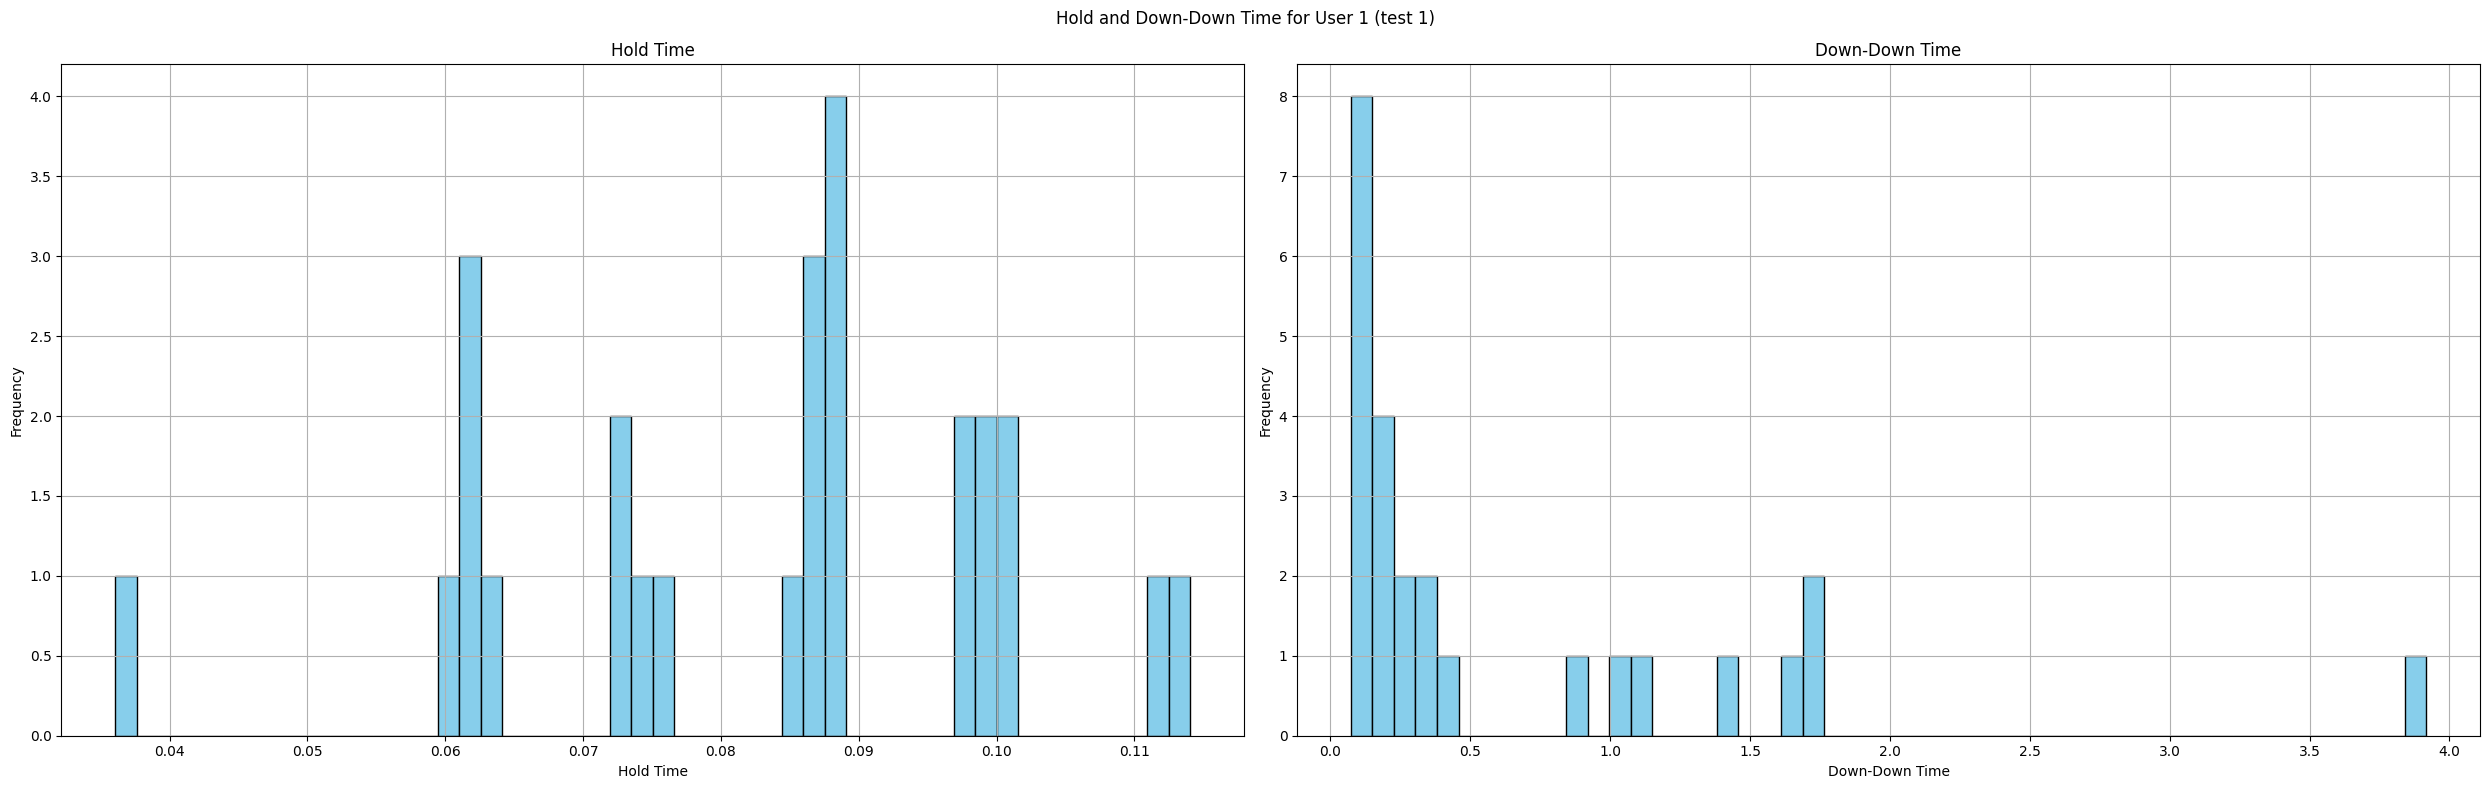

In [12]:
## Histogramm for Hold time and down time for user 1, test 1.

# Read the data
h_d_user1_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_1/true_data/test_1.csv')

# Create subplots for both variables
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# Plot histogram for Hold Time
ax[0].hist(h_d_user1_1['Hold_Time'], bins=50, color='skyblue', edgecolor='black')
ax[0].set_xlabel('Hold Time')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Hold Time')
ax[0].grid(True)

# Plot histogram for Down-Down Time
ax[1].hist(h_d_user1_1['Down_Down_Time'], bins=50, color='skyblue', edgecolor='black')
ax[1].set_xlabel('Down-Down Time')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Down-Down Time')
ax[1].grid(True)

# Set title for the entire figure
fig.suptitle('Hold and Down-Down Time for User 1 (test 1)')


# Show the plots
plt.tight_layout()
plt.show()


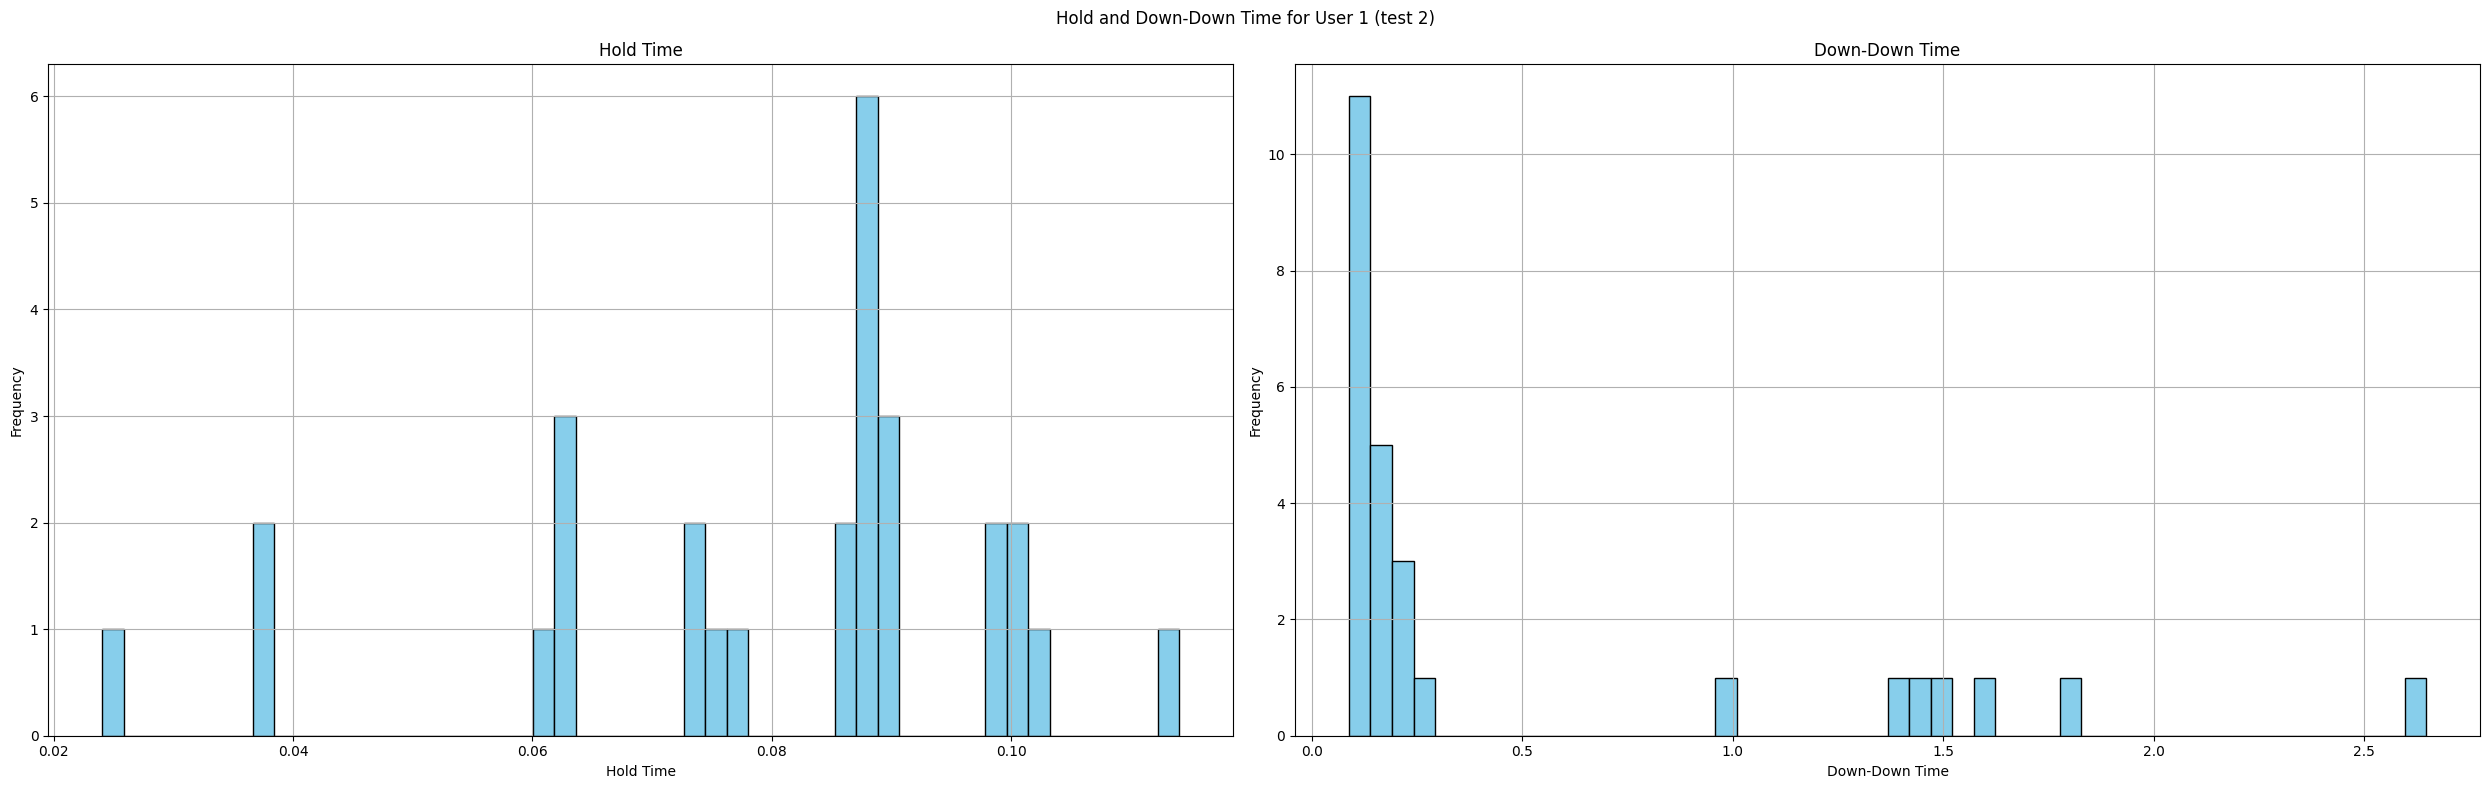

In [14]:
## Histogramm for Hold time and down time for user 1, test 2

# Read the data
h_d_user1_2 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_1/true_data/test_2.csv')
# Create subplots for both variables
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# Plot histogram for Hold Time
ax[0].hist(h_d_user1_2['Hold_Time'], bins=50, color='skyblue', edgecolor='black')
ax[0].set_xlabel('Hold Time')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Hold Time')
ax[0].grid(True)

# Plot histogram for Down-Down Time
ax[1].hist(h_d_user1_2['Down_Down_Time'], bins=50, color='skyblue', edgecolor='black')
ax[1].set_xlabel('Down-Down Time')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Down-Down Time')
ax[1].grid(True)

# Set title for the entire figure
fig.suptitle('Hold and Down-Down Time for User 1 (test 2)')

# Show the plots
plt.tight_layout()
plt.show()


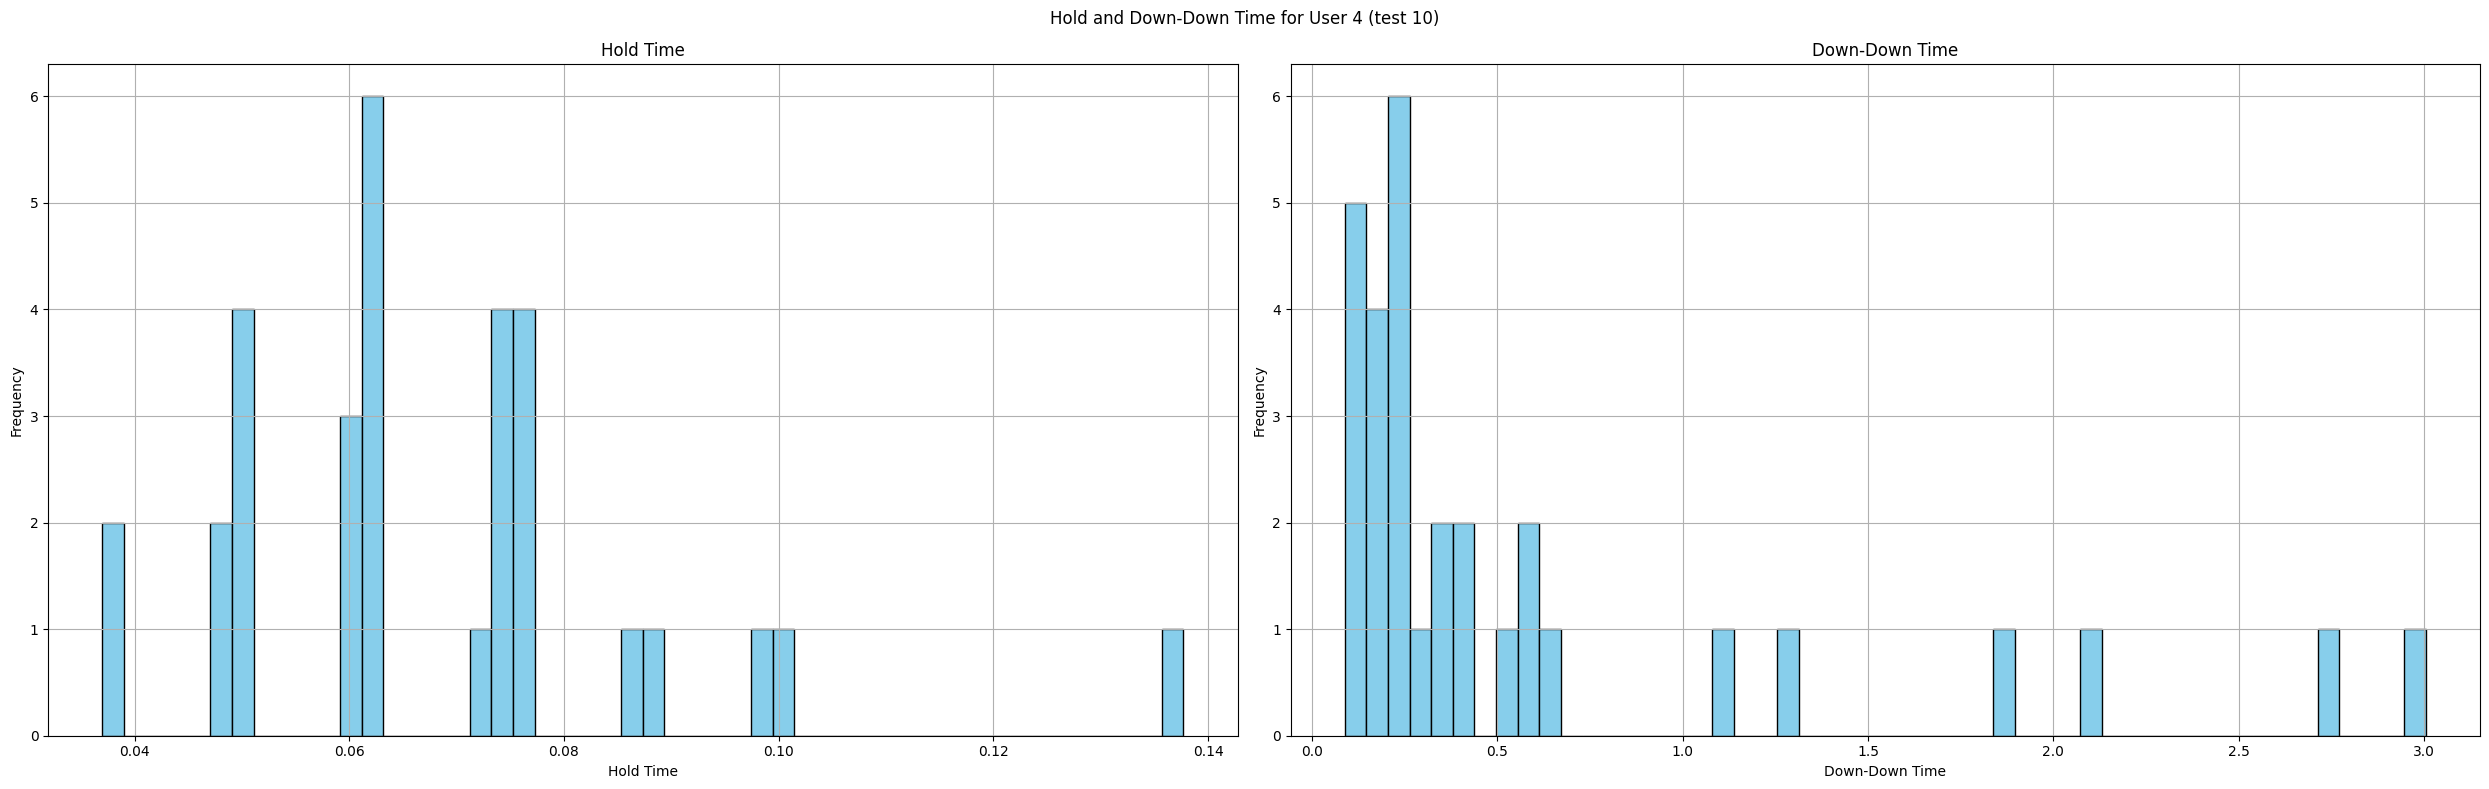

In [15]:
## Histogramm for Hold time and down time for user 4, test 10

# Read the data
h_d_user4_10 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_4/true_data/test_10.csv')

# Create subplots for both variables
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# Plot histogram for Hold Time
ax[0].hist(h_d_user4_10['Hold_Time'], bins=50, color='skyblue', edgecolor='black')
ax[0].set_xlabel('Hold Time')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Hold Time')
ax[0].grid(True)

# Plot histogram for Down-Down Time
ax[1].hist(h_d_user4_10['Down_Down_Time'], bins=50, color='skyblue', edgecolor='black')
ax[1].set_xlabel('Down-Down Time')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Down-Down Time')
ax[1].grid(True)

# Set title for the entire figure
fig.suptitle('Hold and Down-Down Time for User 4 (test 10)')

# Show the plots
plt.tight_layout()
plt.show()


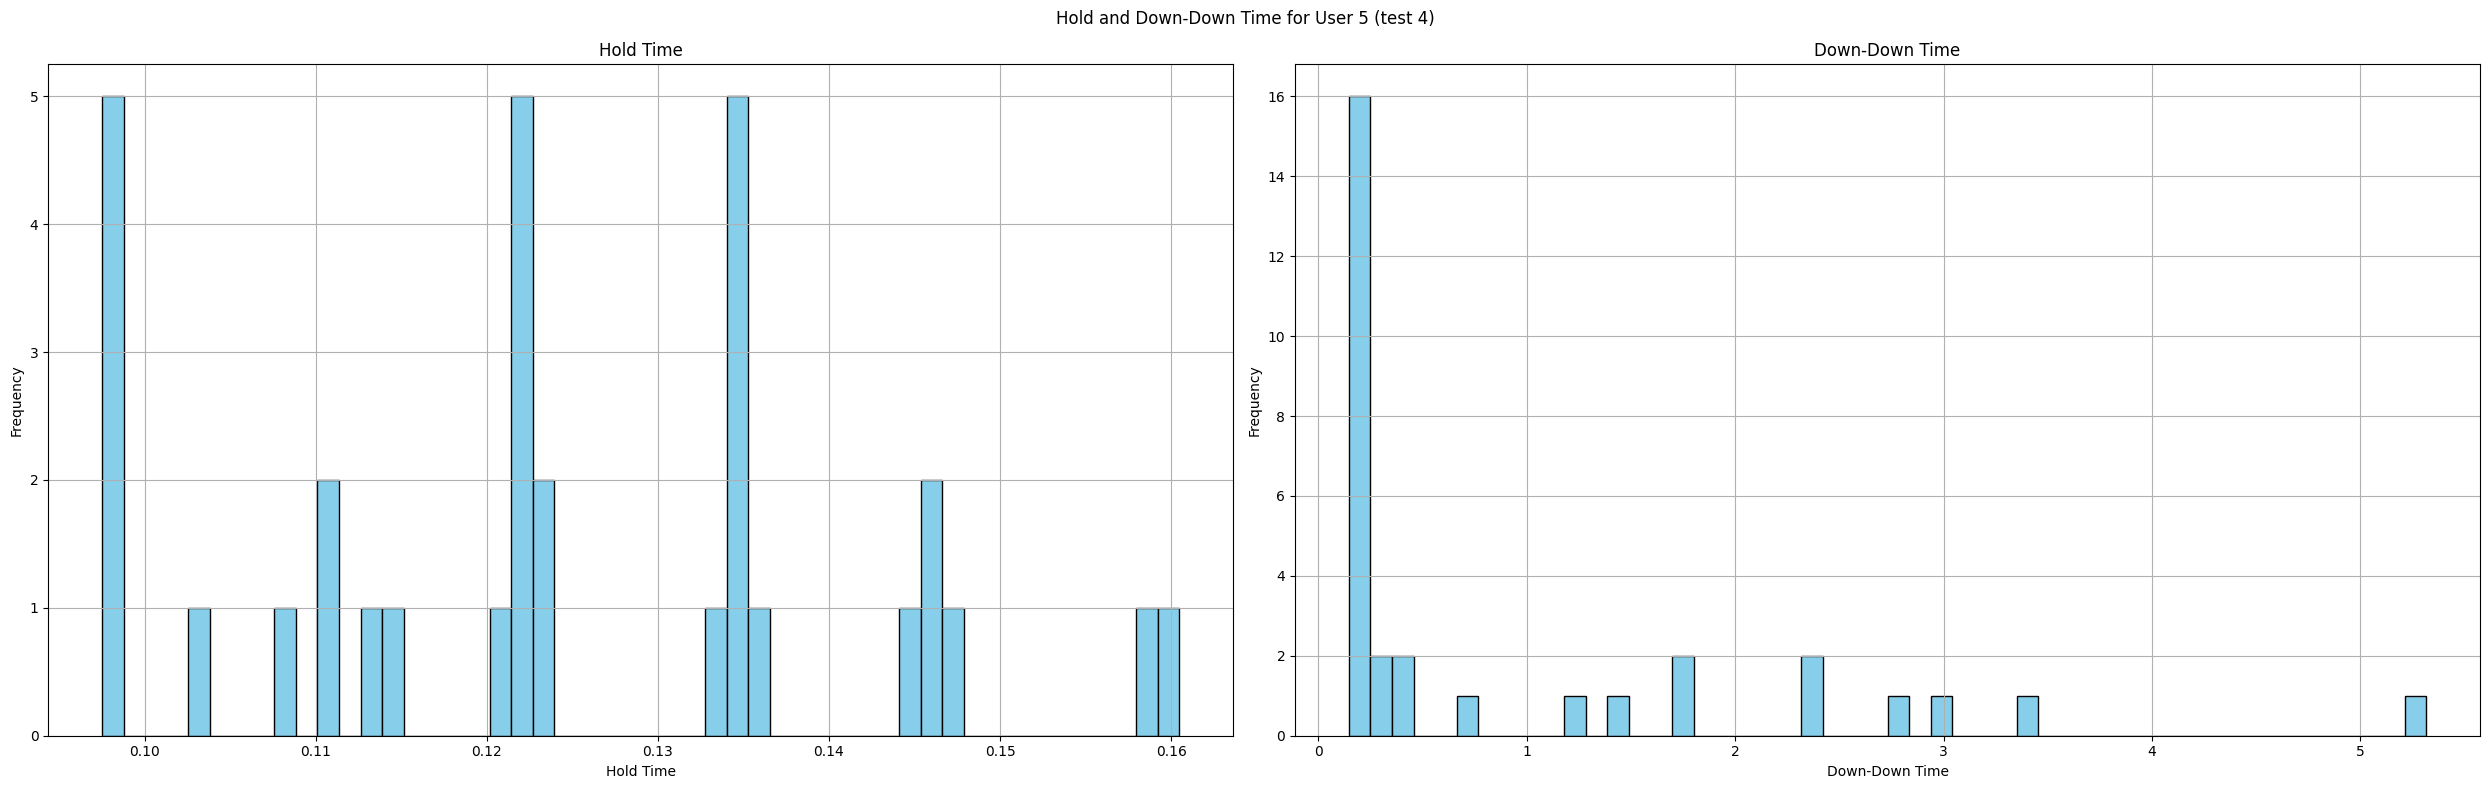

In [16]:
## Histogramm for Hold time and down time for user 5, test 4

# Read the data
h_d_user5_4 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_5/true_data/test_4.csv')

# Create subplots for both variables
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# Plot histogram for Hold Time
ax[0].hist(h_d_user5_4['Hold_Time'], bins=50, color='skyblue', edgecolor='black')
ax[0].set_xlabel('Hold Time')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Hold Time')
ax[0].grid(True)

# Plot histogram for Down-Down Time
ax[1].hist(h_d_user5_4['Down_Down_Time'], bins=50, color='skyblue', edgecolor='black')
ax[1].set_xlabel('Down-Down Time')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Down-Down Time')
ax[1].grid(True)

# Set title for the entire figure
fig.suptitle('Hold and Down-Down Time for User 5 (test 4)')

# Show the plots
plt.tight_layout()
plt.show()


### Histogramm for speed movement

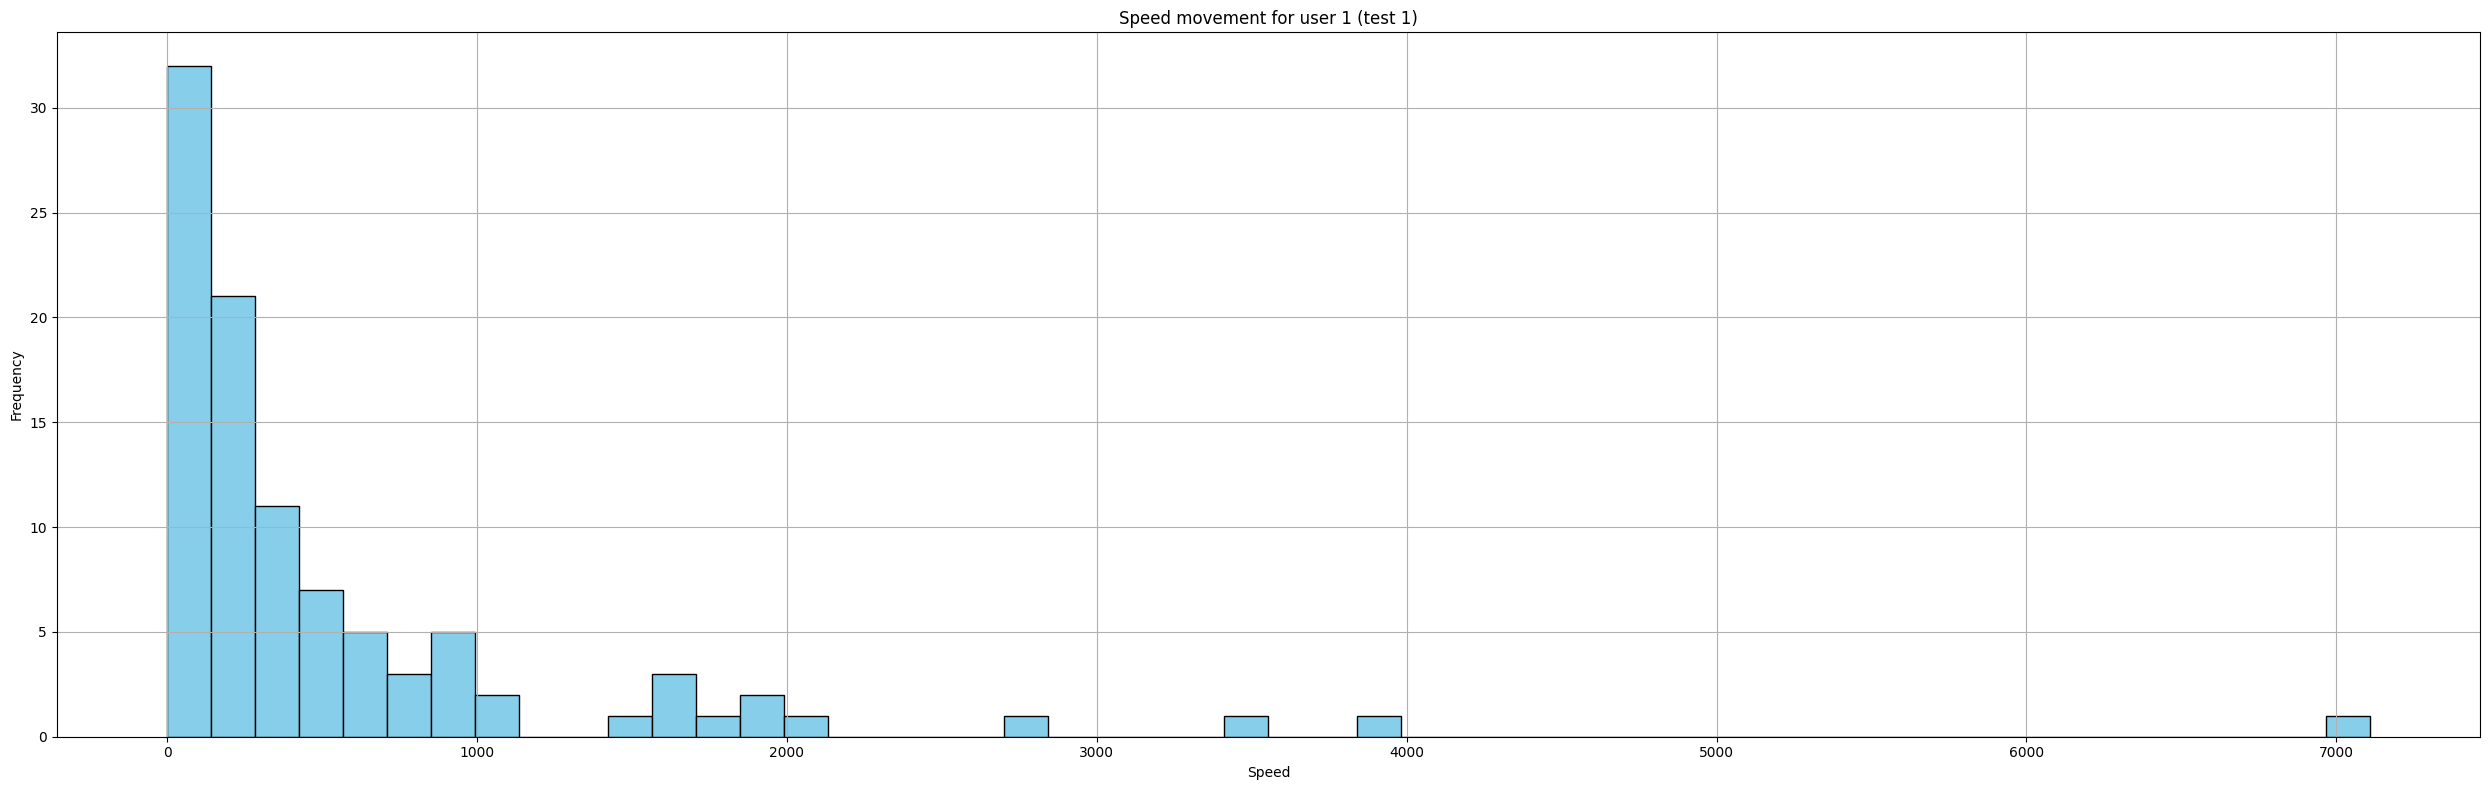

In [18]:
## Histogramm for speed movement for user 1, test 1

# Read the data
speed_user1_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Mouse_features/User_1/true_data/speed_test_1.csv')

# Create subplots for both variables
fig, ax = plt.subplots(figsize=(25, 8))

# Plot histogram for Hold Time
ax.hist(speed_user1_1['Speed'], bins=50, color='skyblue', edgecolor='black')
ax.set_xlabel('Speed')
ax.set_ylabel('Frequency')
ax.set_title('Speed movement for user 1 (test 1)')
ax.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


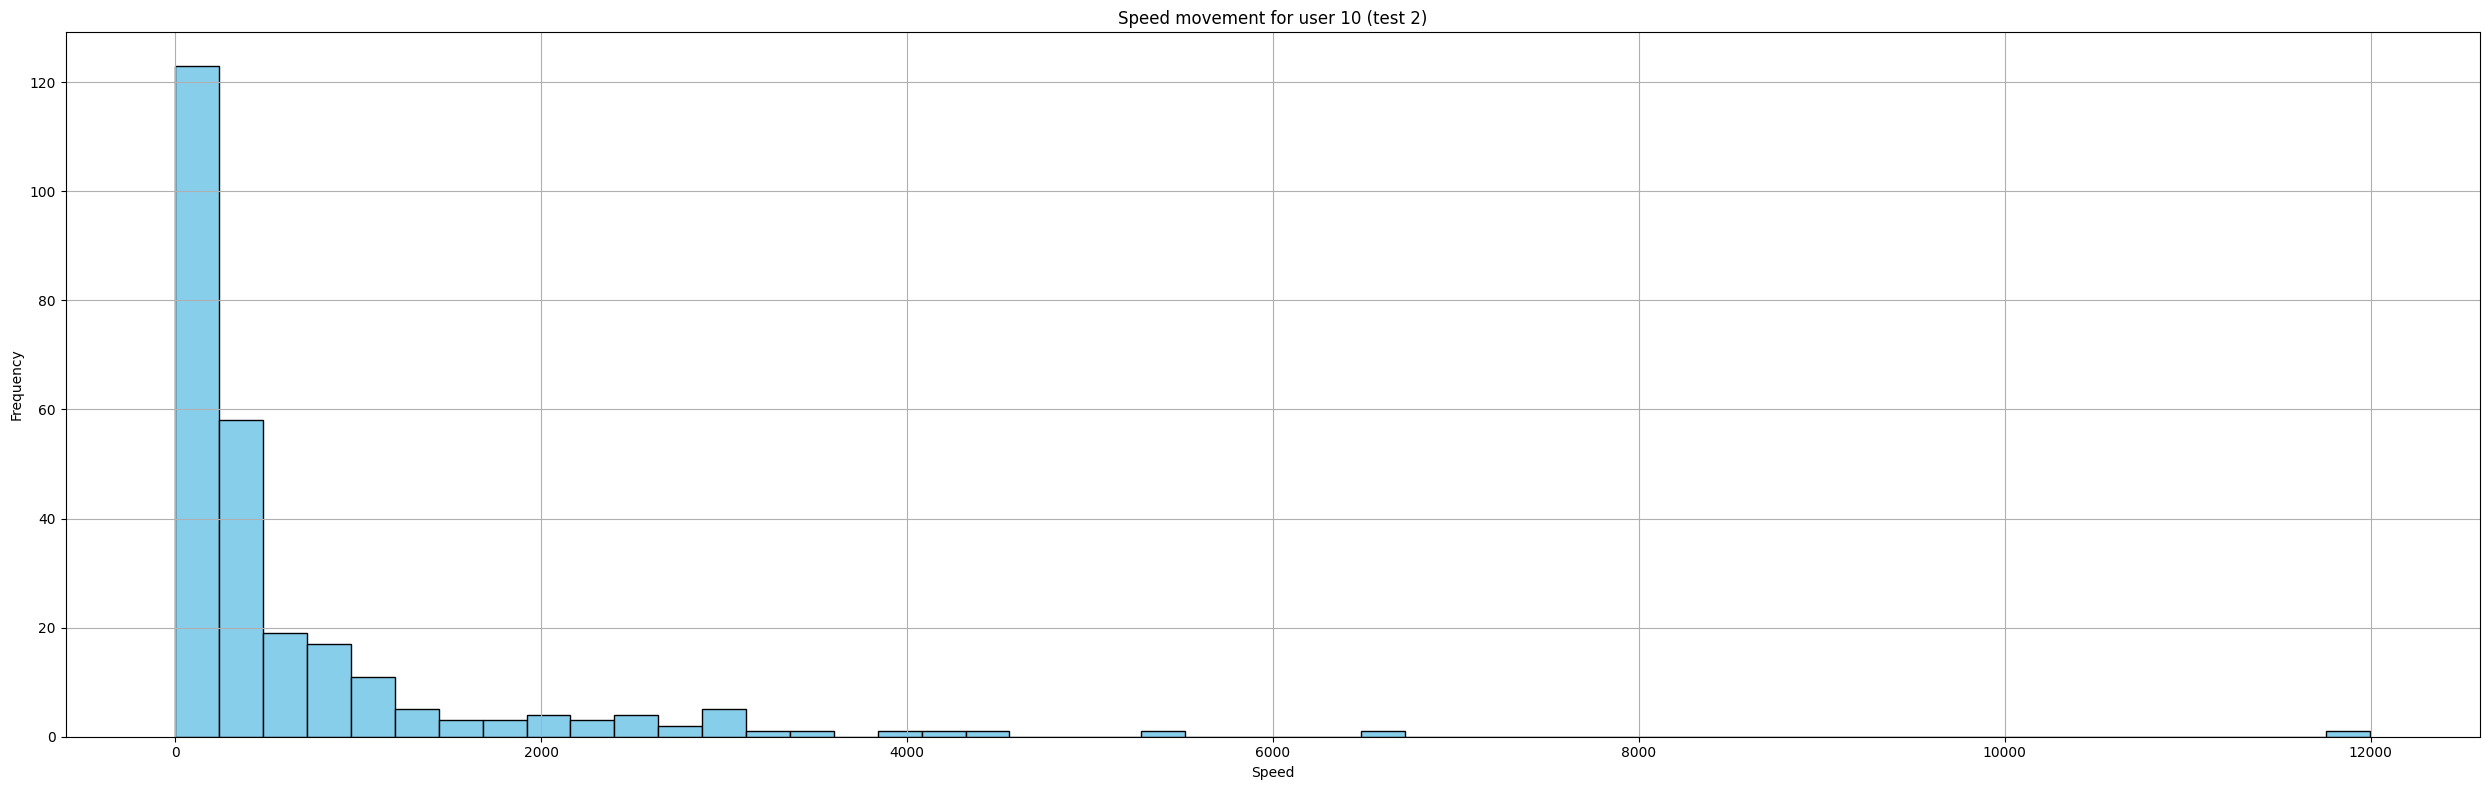

In [19]:
## Histogramm for speed movement for user 10, test 2

# Read the data
speed_user10_2 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Mouse_features/User_10/true_data/speed_test_2.csv')

# Create subplots for both variables
fig, ax = plt.subplots(figsize=(25, 8))

# Plot histogram for Hold Time
ax.hist(speed_user10_2['Speed'], bins=50, color='skyblue', edgecolor='black')
ax.set_xlabel('Speed')
ax.set_ylabel('Frequency')
ax.set_title('Speed movement for user 10 (test 2)')
ax.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


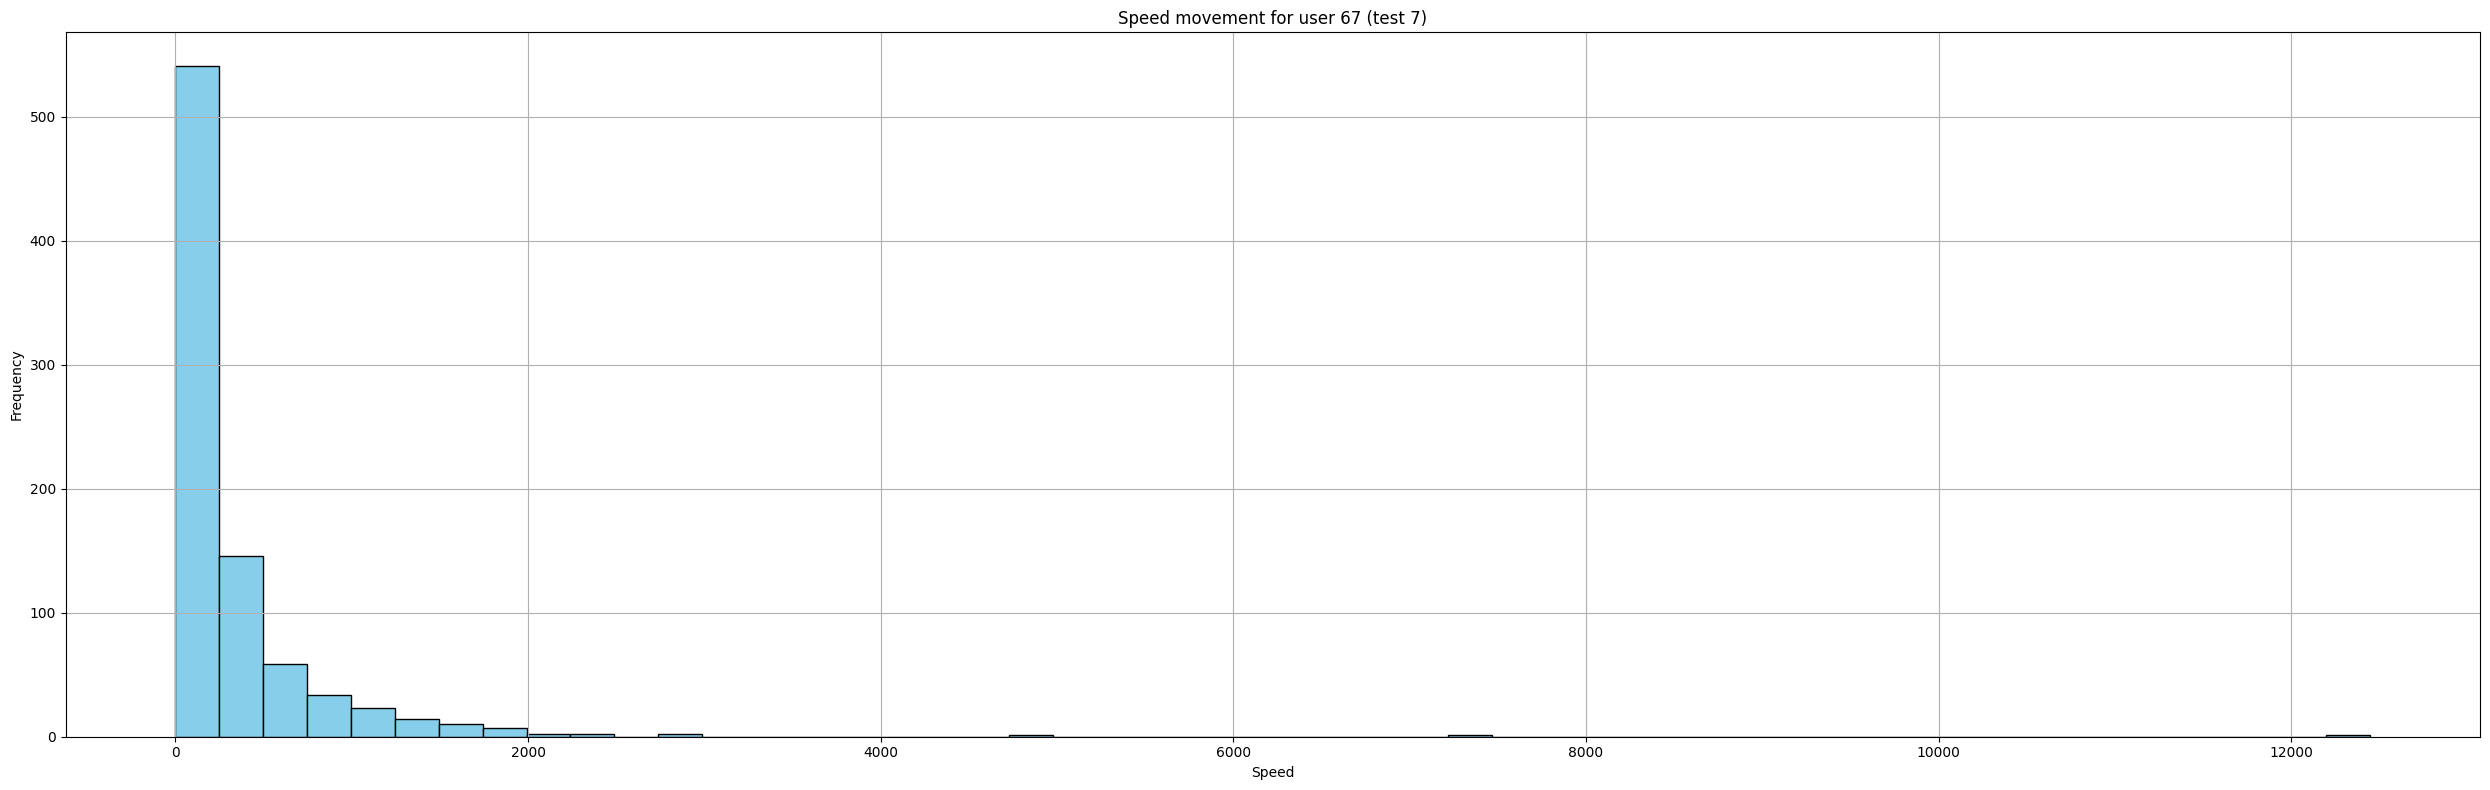

In [20]:
## Histogramm for speed movement for user 67, test 7

# Read the data
speed_user67_7 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Mouse_features/User_67/true_data/speed_test_7.csv')

# Create subplots for both variables
fig, ax = plt.subplots(figsize=(25, 8))

# Plot histogram for Hold Time
ax.hist(speed_user67_7['Speed'], bins=50, color='skyblue', edgecolor='black')
ax.set_xlabel('Speed')
ax.set_ylabel('Frequency')
ax.set_title('Speed movement for user 67 (test 7)')
ax.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

### Probability Density Function (PDF) for Hold time and Down Down time

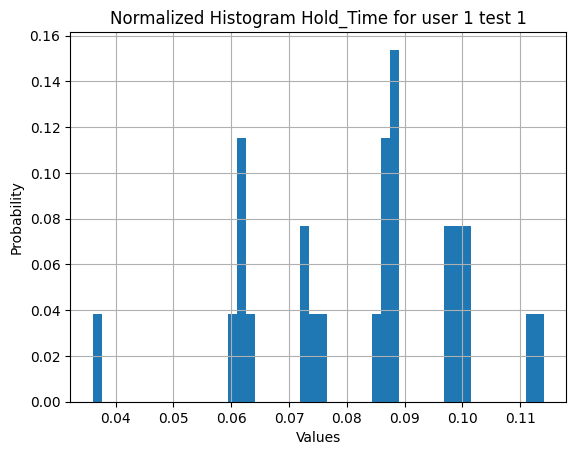

In [23]:
## Normalized histogramm for Hold time for user 1, test 1.

# Read the data
h_d_user1_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_1/true_data/test_1.csv')
normalized_histogram(h_d_user1_1, label='Hold_Time', user= 'user 1', test=1)


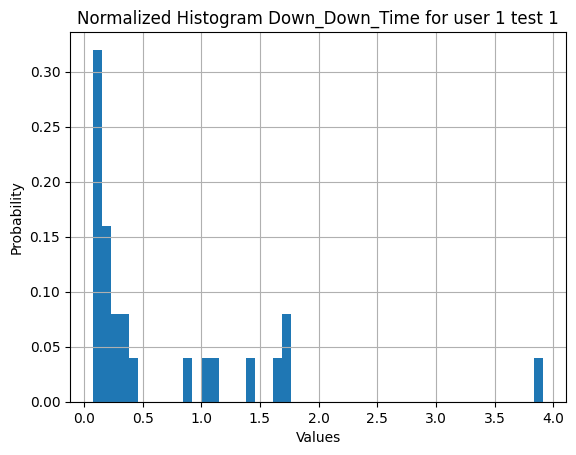

In [24]:
## Normalized histogramm for Down Down time for user 1, test 1.

# Read the data
h_d_user1_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_1/true_data/test_1.csv')
normalized_histogram(h_d_user1_1, label='Down_Down_Time', user= 'user 1', test=1)

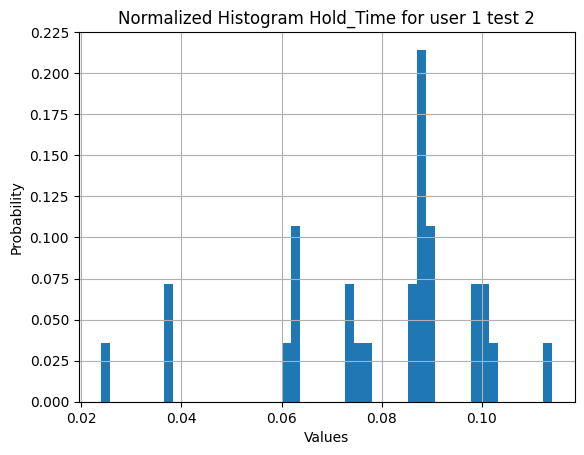

In [27]:
## Histogramm for Hold time for user 1, test 2

# Read the data
h_d_user1_2 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_1/true_data/test_2.csv')
normalized_histogram(h_d_user1_2, label='Hold_Time', user='user 1', test='2')

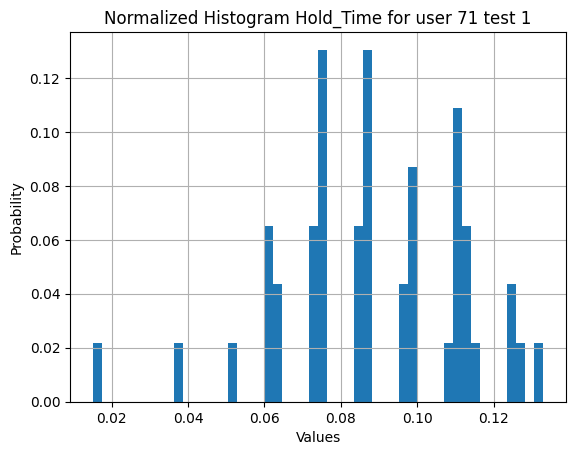

In [28]:
## Normalized histogramm for Hold time for user 71, test 1.

# Read the data
h_d_user71_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_71/true_data/test_1.csv')
normalized_histogram(h_d_user71_1, label='Hold_Time', user= 'user 71', test=1)


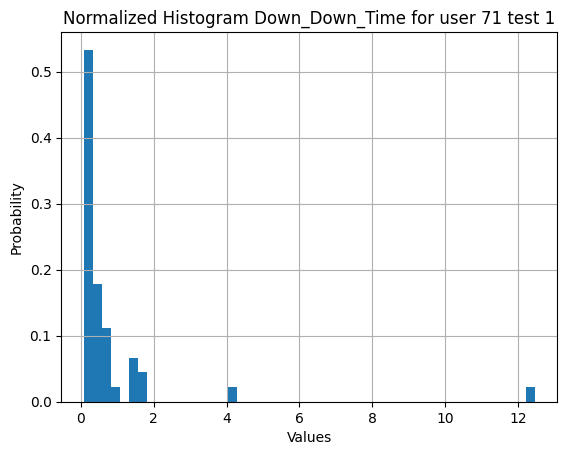

In [29]:
## Normalized histogramm for Hold time for user 71, test 1.

# Read the data
h_d_user71_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Keyboard_features/User_71/true_data/test_1.csv')
normalized_histogram(h_d_user71_1, label='Down_Down_Time', user= 'user 71', test=1)


### Probability Density Function (PDF) for speed movement

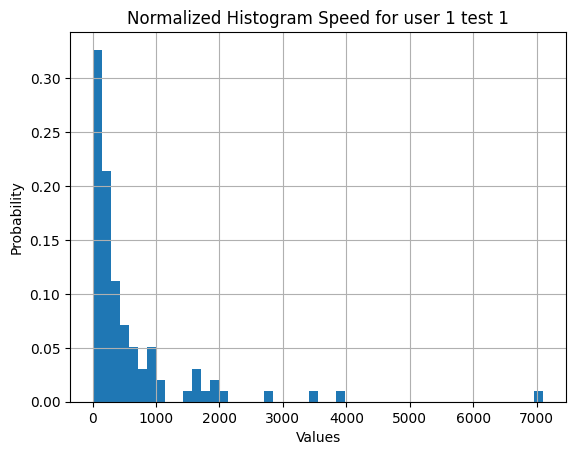

In [30]:
## Histogramm for speed movement for user 1, test 1

# Read the data
speed_user1_1 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Mouse_features/User_1/true_data/speed_test_1.csv')

normalized_histogram(speed_user1_1, label='Speed', user='user 1', test=1)

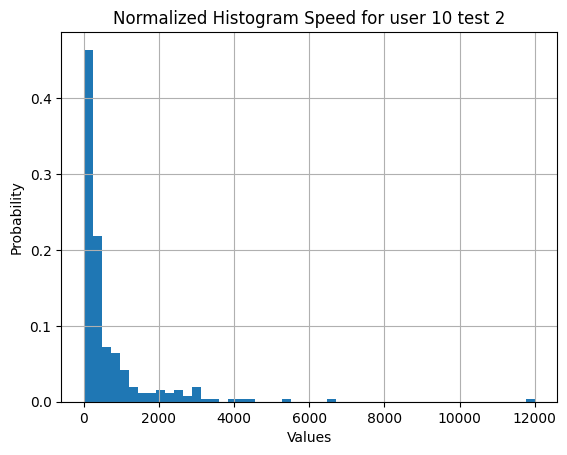

In [31]:
## Histogramm for speed movement for user 10, test 2

# Read the data
speed_user10_2 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Mouse_features/User_10/true_data/speed_test_2.csv')

normalized_histogram(speed_user10_2, label='Speed', user='user 10', test=2)

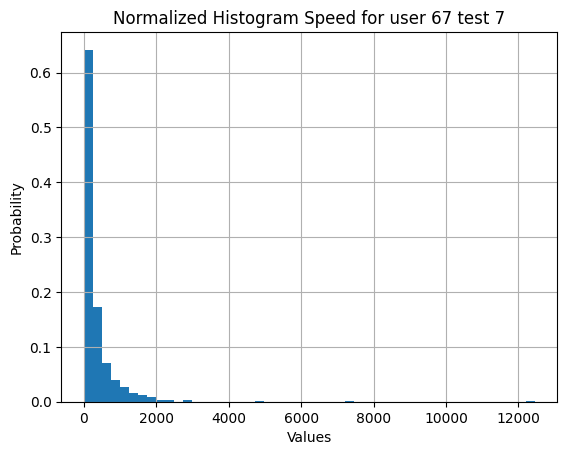

In [32]:
## Histogramm for speed movement for user 67, test 7

# Read the data
speed_user67_7 = pd.read_csv('/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/Features_extracted/Mouse_features/User_67/true_data/speed_test_7.csv')
normalized_histogram(speed_user67_7, label='Speed', user='user 67', test=7)

# Data generation test for user_1, here we will use Gaussian Mixture Model

In [ ]:
from pathlib import Path
Path = '/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/raw_kmt_dataset/raw_kmt_user_0001.json'

In [ ]:
#Create a dictionary dataset with all the data for each user,
#where keys are dataset names and values are DataFrames. Ex: feature_kmt_user_0048

# Directory where your datasets are stored
directory = '/content/drive/MyDrive/Dataset/behaviour_biometrics_dataset/feature_kmt_dataset/feature_kmt_xlsx'

# List all files in the directory
files = os.listdir(directory)

# Iterate over the files and read each dataset
datasets = {}
for file in files:
    if file.endswith('.xlsx'):
        file_path = os.path.join(directory, file)
        dataset_name = os.path.splitext(file)[0]  # Extract dataset name from filename
        datasets[dataset_name] = pd.read_excel(file_path)   # Read dataset into a pandas DataFrame


In [ ]:
data_user_1 = datasets['feature_kmt_user_0001']

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from scipy.stats import norm
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
original_data = datasets['feature_kmt_user_0001']

# Select features
X = np.array(original_data[['dwell_avg', 'flight_avg', 'traj_avg']])

# Define the parameter grid to search
param_grid = {
    'n_components': [2, 3, 4],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5],
    'max_iter': [50, 75, 100, 200],
    'init_params': ['kmeans', 'random']
}



# Create GMM instance
gmm = GaussianMixture(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(gmm, param_grid, cv=6)
grid_search.fit(X)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Generate synthetic data using the best parameters
best_gmm = grid_search.best_estimator_
synthetic_data = best_gmm.sample(5000)

# Convert synthetic data to a DataFrame
synthetic_df = pd.DataFrame(synthetic_data[0], columns=['dwell_avg', 'flight_avg', 'traj_avg'])

# Create a DataFrame for synthetic labels
label = pd.DataFrame(synthetic_data[1], columns=['label'])

# Concatenate synthetic data with its labels
synthetic_gm = pd.concat([synthetic_df, label], axis=1)

Best parameters found:
{'covariance_type': 'diag', 'init_params': 'kmeans', 'max_iter': 50, 'n_components': 2, 'tol': 0.01}


### Plotting PDFs for each feature

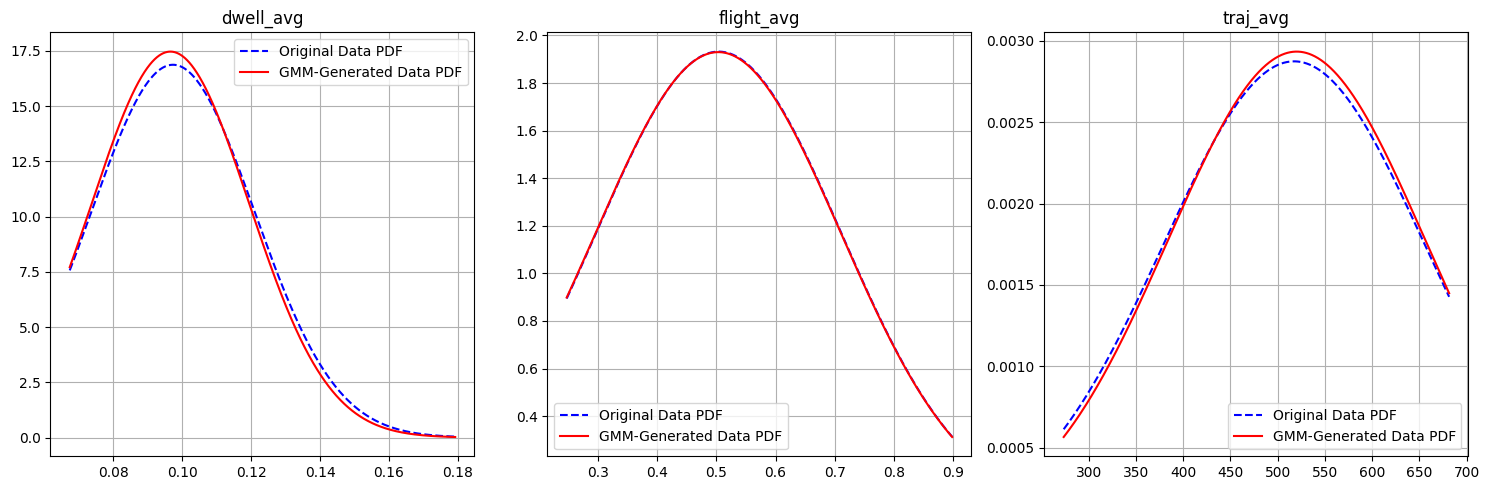

In [ ]:
# Plot PDFs for each feature
features = ['dwell_avg', 'flight_avg', 'traj_avg']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(features):
    # Plot histogram of original data
#     axs[i].hist(original_data[feature], bins=30, density=True, alpha=0.5, color='blue', label='Original Data')

    # Calculate PDF for original data
    x = np.linspace(original_data[feature].min(), original_data[feature].max(), 1000)
    original_pdf = norm.pdf(x, loc=np.mean(original_data[feature]), scale=np.std(original_data[feature]))

    # Plot PDF for original data
    axs[i].plot(x, original_pdf, color='blue', linestyle='--', label='Original Data PDF')

    # Calculate PDF for GMM-generated data
    synthetic_feature_data = synthetic_data[0][:, i]
    gmm_pdf = norm.pdf(x, loc=np.mean(synthetic_feature_data), scale=np.std(synthetic_feature_data))

    # Plot PDF for GMM-generated data
    axs[i].plot(x, gmm_pdf, color='red', linestyle='-', label='GMM-Generated Data PDF')

    axs[i].set_title(feature)
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()

plt.show()

In [ ]:
original_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,20.0,9.500000,5.916080,0.000000,4.750000,9.500000,14.25000,19.000000
dwell_avg,20.0,0.097350,0.024256,0.067409,0.087558,0.091366,0.09781,0.179208
flight_avg,20.0,0.504119,0.211855,0.247867,0.357291,0.414779,0.67442,0.897945
traj_avg,20.0,517.383399,142.378992,273.365884,407.821618,547.730428,663.54162,681.614430
label,20.0,0.500000,0.512989,0.000000,0.000000,0.500000,1.00000,1.000000


In [ ]:
synthetic_gm.describe().T

,count,mean,std,min,25%,50%,75%,max
dwell_avg,5000.0,0.096611,0.022838,-0.029084,0.088256,0.091986,0.098110,0.219529
flight_avg,5000.0,0.503457,0.206738,0.047053,0.360608,0.418713,0.627364,1.378944
traj_avg,5000.0,520.118467,135.955881,5.896148,428.002802,550.862840,620.160668,832.523737
label,5000.0,0.411000,0.492064,0.000000,0.000000,0.000000,1.000000,1.000000


In [ ]:
# Statistic test of Kolmogorov-Smirnov
ks_results = {}
for column in original_data.columns[1:-1]:  # Ignorer la dernière colonne (étiquette)
    ks_stat, ks_p_value = ks_2samp(original_data[column], synthetic_gm[column])
    ks_results[column] = {'KS statistic': ks_stat, 'p-value': ks_p_value}

print("\nResul test of Kolmogorov-Smirnov :\n")
for column, result in ks_results.items():
    print(f"{column}: KS statistic = {result['KS statistic']}, p-value = {result['p-value']:.4f}")



Resul test of Kolmogorov-Smirnov :

dwell_avg: KS statistic = 0.1098, p-value = 0.9489
flight_avg: KS statistic = 0.1328, p-value = 0.8296
traj_avg: KS statistic = 0.183, p-value = 0.4634
